In [1]:
# copyright: https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb
# for personal study purposes only

- X: features (age, fare)
- T: treatment (hasCabin)
- y: survived indicator

- Want to see whether hasCabin affects survival probability
- But treatment assignment is not random, potentially determined by X, which also affects y

- Basically
    - survived = hasCabin + $\epsilon$
    - $\epsilon$ = $\epsilon$(X) is correlated with hasCabin
$$

In [2]:
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics


In [4]:
import math
import pandas as pd

def perform_match_exact(row, df , *args):
    # row is the the item that we want to match
    # df is the source Pandas dataframe that we want to match it with other items
    # print('Start matching')
    sub_set = df
    
    for arg in args:
        sub_set = sub_set.loc[sub_set[arg] == row[arg]]
        # print(sub_set)
        
    return sub_set.index


def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def hasCabin(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [8]:
df = pd.read_csv('train.csv')

df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

df['treatment'] = df.Cabin.apply(hasCabin)


df = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]


In [9]:
df.head()

,treatment,Sex,Age,SibSp,Parch,Embarked,Pclass,Fare
0,0,male,22.0,1,0,S,3,7.2500
1,1,female,38.0,1,0,C,1,71.2833
2,0,female,26.0,0,0,S,3,7.9250
3,1,female,35.0,1,0,S,1,53.1000
4,0,male,35.0,0,0,S,3,8.0500


0.9283707865168539
[[503  26]
 [ 25 158]]
0.8610354223433242


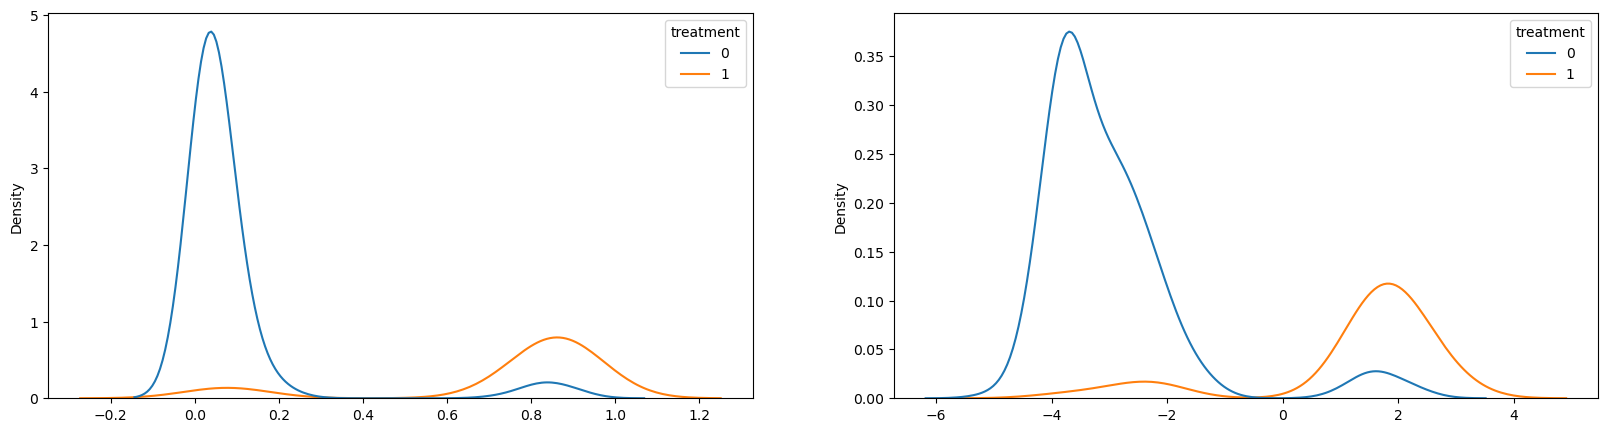

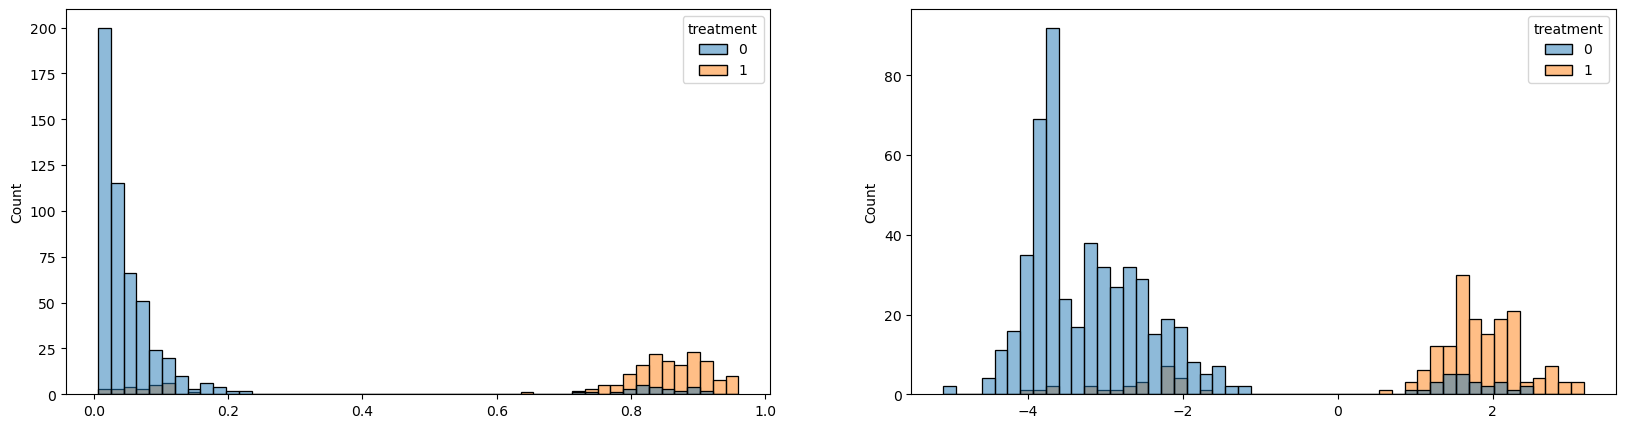

In [20]:
T = df['treatment']
X = df.drop('treatment', axis = 1)
X_encoded = pd.get_dummies(
    X,
    columns = ['Sex','Embarked', 'Pclass'], 
    prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, 
    drop_first=False,
)




# propensity estimate
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('logistic_regression', lr()),
    ]
)
pipe.fit(X_encoded, T)

predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)
predictions_logit = np.array([logit(x) for x in predictions[:, 1]])


X_encoded['propensity_score'] = predictions[:,1]
X_encoded['propensity_score_logit'] = predictions_logit
X_encoded['outcome'] = y.Survived
X_encoded['treatment'] = df['treatment']




# how well is propensity estimate
print(metrics.accuracy_score(T, predictions_binary))
print(metrics.confusion_matrix(T, predictions_binary))
print(metrics.f1_score(T, predictions_binary))

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.kdeplot(x = predictions[:, 1], hue = T, ax = ax[0])
sns.kdeplot(x = predictions_logit, hue = T, ax = ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.histplot(x = predictions[:, 1], hue = T, bins = 50, ax = ax[0])
sns.histplot(x = predictions_logit, hue = T, bins = 50, ax = ax[1])
plt.show()

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

In [21]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0.021156,-3.834463,0,0
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0.039982,-3.178512,1,0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0.019913,-3.896294,0,0


## Matching

In [24]:
caliper = np.std(
    X_encoded['propensity_score']
) * 0.25

print(f'caliper = {caliper}')


knn = NearestNeighbors(
    n_neighbors=10,
    p=2,
    radius = caliper,
)
knn.fit(
    X_encoded[['propensity_score_logit']]
)


distances, indexes = knn.kneighbors(
    X_encoded[['propensity_score_logit']],
    n_neighbors=10,
)

caliper = 0.08890268148266277


In [25]:
distances[0, :]

array([0.00000000e+00, 2.13317234e-05, 1.10579784e-03, 4.49038997e-03,
       6.54018876e-03, 6.74858828e-03, 7.11816505e-03, 8.54491653e-03,
       9.79259476e-03, 1.04108109e-02])

In [26]:
indexes[0, :]

array([  0, 607, 539, 301, 590, 641, 611,  36, 134, 449])

In [ ]:
def obtain_match_details(
        row,
        all_data,
        attributes,
):
    

In [29]:
X_encoded

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0.021156,-3.834463,0,0
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0.039982,-3.178512,1,0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0.019913,-3.896294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,39.0,0,5,29.1250,1,0,0,1,0,0,0,1,0.068306,-2.613010,0,0
708,27.0,0,0,13.0000,0,1,0,0,1,0,1,0,0.066783,-2.637188,0,0
709,19.0,0,0,30.0000,1,0,0,0,1,1,0,0,0.931490,2.609811,1,1
710,26.0,0,0,30.0000,0,1,1,0,0,1,0,0,0.849575,1.731272,1,1
